## Step 0: Install and Import Dependencies 환경설정

In [1]:
!pip install -q torchinfo

In [ ]:
import torch
from torch import nn
from torchinfo import summary


# Step 1: Get the Data 데이터셋 다운로드

1.1. Download the Data from the Web (It will be a .zip file for this)

1.2. Extract the zip file

1.3. Delete the zip file

In [ ]:
import requests
from pathlib import Path
import os
from zipfile import ZipFile

# Define the URL for the zip file
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

# Send a GET request to download the file
response = requests.get(url)

# Define the path to the data directory
data_path = Path("data")

# Define the path to the image directory
image_path = data_path / "pizza_steak_sushi"

# Check if the image directory already exists
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Write the downloaded content to a zip file
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    f.write(response.content)

# Extract the contents of the zip file to the image directory
with ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zipref:
    zipref.extractall(image_path)

# Remove the downloaded zip file
os.remove(data_path / 'pizza_steak_sushi.zip')


Did not find data/pizza_steak_sushi directory, creating one...


# Step 2: Define Transformations 이미지 변환 정의

1. Resize the images using `Resize()` to 224. We choose the images size to be 224 based on the ViT Paper

2. Convert to Tensor using `ToTensor()`

In [ ]:
from torchvision.transforms import Resize, Compose, ToTensor

# Define the train_transform using Compose
train_transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

# Define the test_transform using Compose
test_transform = Compose([
    Resize((224, 224)),
    ToTensor()
])

# Step 3: Create Dataset and DataLoader 데이터셋과 데이터로더 준비

We can use PyTorch's ImageFolder DataSet library to create our Datasets.

For ImageFolder to work this is how your data folder needs to be structured.

```markdown
data
└── pizza_steak_sushi
    ├── test
    │   ├── pizza
    │   ├── steak
    │   └── sushi
    └── train
        ├── pizza
        ├── steak
        └── sushi
```
All the `pizza` images will be in the pizza folder of train and test sub folders and so on for all the classes that you have.

There are two useful methods that you can call on the created `training_dataset` and `test_dataset`

1. `training_dataset.classes` that gives `['pizza', 'steak', 'sushi']`
2. `training_dataset.class_to_idx` that gives `{'pizza': 0, 'steak': 1, 'sushi': 2}`


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Define the data directory
data_dir = Path("data/pizza_steak_sushi")

# Create the training dataset using ImageFolder
training_dataset = ImageFolder(root=data_dir / "train", transform=train_transform)

# Create the test dataset using ImageFolder
test_dataset = ImageFolder(root=data_dir / "test", transform=test_transform)

# Create the training dataloader using DataLoader
training_dataloader = DataLoader(
    dataset=training_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2
)

# Create the test dataloader using DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=2
)



We can visualize a few training dataset images and see their labels

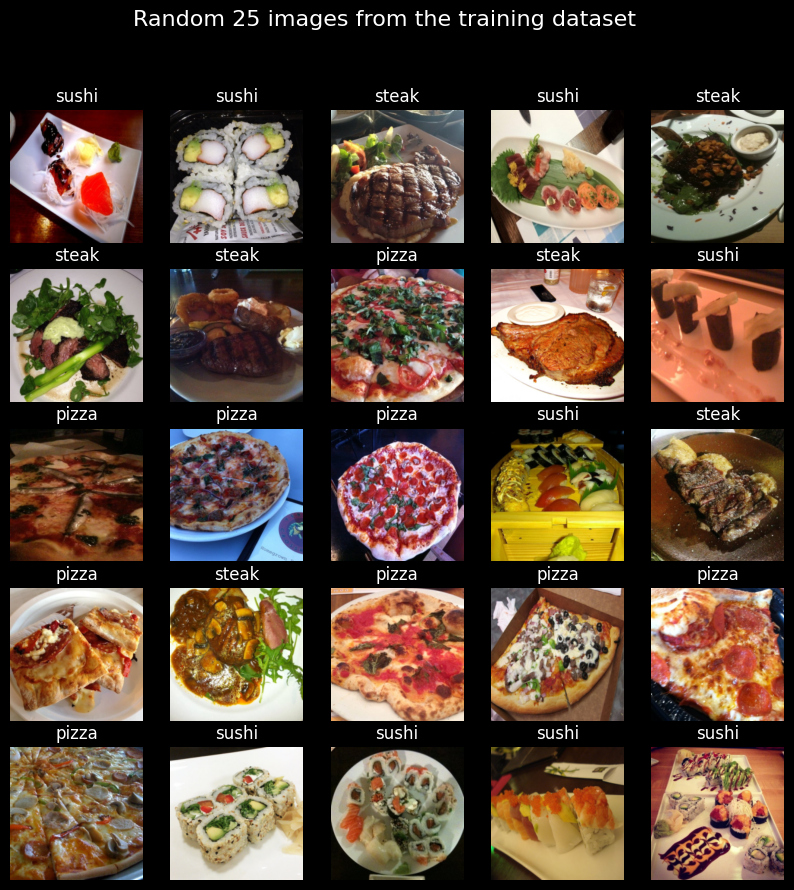

In [ ]:
import matplotlib.pyplot as plt
import random

num_rows = 5
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(training_dataset))

        # Display the image in the subplot
        axs[i, j].imshow(training_dataset[image_index][0].permute((1, 2, 0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(training_dataset.classes[training_dataset[image_index][1]], color="white")

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(f"Random {num_rows * num_cols} images from the training dataset", fontsize=16, color="white")

# Set the background color of the figure as black
fig.set_facecolor(color='black')

# Display the plot
plt.show()


# 밑의 과정은 README에 정리
# Step 4: Create Patch Embedding Layer

For the ViT paper we need to perform the following functions on the image before passing to the MultiHead Self Attention Transformer Layer

1. Convert the image into patches of 16 x 16 size.
2. Embed each patch into 768 dimensions. So each patch becomes a `[1 x 768] ` Vector. There will be $N = \frac{H \times W}{P^2}$ number of patches for each image. This results in an image that is of the shape `[14 x 14 x 768]`
3.  Flatten the image along a single vector. This will give a `[196 x 768]` Matrix which is our Image Embedding Sequence.
4. Prepend the Class Token Embeddings to the above output
5. Add the Position Embeddings to the Class Token and Image Embeddings.




![Vision Tranformer Steps](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif)

In [ ]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

#the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")



## Step 4.1 Converting the image into patches of 16 x 16 and creating an embedding vector for each patch of size 768.

This can be accomplished by using a Conv2D Layer with a kernel_size equal to patch_size and a stride equal to patch_size

![Convolution plus Flatten](https://res.cloudinary.com/dltwftrgc/image/upload/v1686832476/Blogs/Vision-Transformer/CNN_Flatten_vfq1q6.png)



In [ ]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

We can pass a random image into the convolutional layer and see what happens

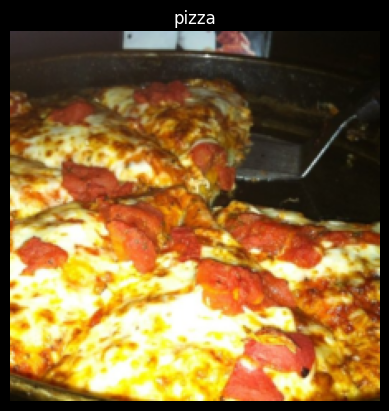

In [ ]:
random_images, random_labels = next(iter(training_dataloader))
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

# Display the random image
plt.imshow(random_image.permute((1, 2, 0)))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(training_dataset.classes[random_labels[0]], color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")


We need to change the shape to `[1, 14, 14, 768]` and flatten the output to `[1, 196, 768]`

In [ ]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten


Shape of embeddings through the conv layer -> [1, 768, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 196, 768] <- [batch_size, num_of_patches, embedding_dims]


## 4.2. Prepending the Class Token Embedding and Adding the Position Embeddings

In [ ]:
class_token_embeddings = nn.Parameter(torch.rand((1, 1,EMBEDDING_DIMS), requires_grad  = True))
print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embedding_dims]')

position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')


Shape of class_token_embeddings --> [1, 1, 768] <-- [batch_size, 1, emdedding_dims]

Shape of image embeddings with class_token_embeddings --> [1, 197, 768] <-- [batch_size, num_of_patches+1, embedding_dims]

Shape of position_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]

Shape of final_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]


Shape of `class_token_embeddings` --> `[1, 1, 768]` <-- `[batch_size, 1, emdedding_dims]`

Shape of `image embeddings with class_token_embeddings` --> `[1, 197, 768]` <-- `[batch_size, num_of_patches+1, embeddiing_dims]`

Shape of `position_embeddings` --> `[1, 197, 768]` <-- `[batch_size, num_patches+1, embeddings_dims]`

Shape of `final_embeddings` --> `[1, 197, 768]` <-- `[batch_size, num_patches+1, embeddings_dims]`

## Put the PatchEmbedddingLayer Together

We will inherit from the PyTorch `nn.Module` to create our custom layer which takes in an image and throws out the patch embeddings which consists of the Image Embeddings, Class Token Embeddings and the Position Embeddings.

In [ ]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output


In [ ]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)

patch_embeddings = patch_embedding_layer(random_images)
patch_embeddings.shape


torch.Size([32, 197, 768])

In [ ]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [32, 3, 224, 224]    [32, 197, 768]       175,872              True
├─Conv2d (conv_layer)                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Flatten (flatten_layer)                     [32, 14, 14, 768]    [32, 196, 768]       --                   --
Total params: 766,464
Trainable params: 766,464
Non-trainable params: 0
Total mult-adds (G): 3.70
Input size (MB): 19.27
Forward/backward pass size (MB): 38.54
Params size (MB): 2.36
Estimated Total Size (MB): 60.17

# Step 5. Creating the Multi-Head Self Attention (MSA) Block.





## Understanding MSA Block

As a first step of putting together our transformer block for the Vision Transformer model, we will be creating a MultiHead Self Attention Block.

Let us take a moment to understand the MSA Block. The MSA block itself consists of a LayerNorm layer and the Multi-Head Attention Layer. The layernorm layer essentially normalizes our patch embeddings data across the embeddings dimension. The Multi-Head Attention layer takes in the input data as 3 form of learnable vectors namely **query**, **key** and **value**, collectively known as **qkv** vectors. These vectors together form the relationship between each patch of the input sequence with every other patch in the same sequence (hence the name **self-attention**).

So, our input shape to the MSA Block will be the shape of our patch embeddings that we made using the PatchEmbeddingLayer -> `[batch_size, sequence_length, embedding_dimensions]`. And the output from the MSA layer will be of the same shape as the input.

## MSA Block Code

Now let us begin to write code for out MSA Block. This will be short as PyTorch has a pre-built implementation of [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) and the [MultiHeadAttention Layer](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html). We just have to pass the right arguments to suit our architecture. We can find the various parameters that are required for out MSA block in this table from the original ViT Paper.

<img src ="https://res.cloudinary.com/dltwftrgc/image/upload/v1686983012/Blogs/Vision-Transformer/ViT-model-variants_gfeotm.png">

In [ ]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

## Let's test our MSA Block

In [ ]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = EMBEDDING_DIMS,
                                                             num_heads = 12
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


Beautiful, so seems like our MSA block is working. We can get more information about the MSA Block using torchinfo

In [ ]:
summary(model=multihead_self_attention_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                      [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multiheadattention)                    --                   [1, 197, 768]        2,362,368            True
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 1.21
Params size (MB): 0.01
Estimated Total Size (MB): 1.82

# Step 6. Creating the Machine Learning Perceptron (MLP) Block

## Understanding the MLP Block

The Machine Learning Perceptron (MLP) Block in the transformer is a combination of a Fully Connected Layer (also called as a Linear Layer or a Dense Layer) and a non-linear layer. In the case of ViT, the non-linear layer is a GeLU layer.

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_12.48.44_PM.png" width = "300">

The transformer also implements a Dropout layer to reduce overfitting. So the MLP Block will look something like this:

Input --> Linear --> GeLU --> Dropout --> Linear --> Dropout

According to the paper the first Linear Layer scales the embedding dimensions to the 3072 dimensions (for the ViT-16/Base). The Dropout is set to 0.1 and the second Linear Layer scales down the dimensions back to the embedding dimensions.

## MLP Block Code

Let us now assemble our MLP Block. According to the ViT Paper, the output from the MSA Block added to the input to the MSA Block (denoted by the skip/residual connection in the model architecture figure) is passed as input to the MLP Block. All the layers are provided by the PyTorch library. We just need to assemble it.

In [ ]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

## Let's test our MLP Block

In [ ]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = EMBEDDING_DIMS,
                                           mlp_size = 3072,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                           [1, 197, 768]        [1, 197, 768]        1,536                True
├─Sequential (mlp)                                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─GELU (1)                                                   [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                                                [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Linear (3)                                            

Amazing, looks like the MLP Block is also working as expected.

# Step 7. Putting together the Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x


## Testing the Transformer Block

In [ ]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 12)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')


Shape of the input Patch Embeddings => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [32, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [ ]:
summary(model=transformer_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 197, 768]        2,362,368            True
├─MachineLearningPerceptronBlock (mlp_block)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Step 8. Creating the ViT Model

In [ ]:
class ViT(nn.Module):
  def __init__(self, img_size = 224,
               in_channels = 3,
               patch_size = 16,
               embedding_dims = 768,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 1000):
    super().__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [ ]:
vit = ViT(num_classes = 3)
vit(random_images)


tensor([[-0.3139, -0.8287,  0.2093],
        [ 0.1897, -0.5488,  0.3548],
        [ 0.1054, -0.2697,  0.4068],
        [ 0.1975, -0.5093,  0.2158],
        [-0.1908, -0.7027,  0.3543],
        [ 0.2956, -0.6712,  0.4774],
        [ 0.3436, -0.2125,  0.1174],
        [-0.4676, -0.5508,  0.7557],
        [-0.1896, -0.6257,  0.4564],
        [ 0.2640, -0.6425,  0.5411],
        [ 0.1593, -0.3793,  0.7547],
        [ 0.0165, -0.3111,  0.5905],
        [ 0.2065, -0.6964,  0.5873],
        [-0.1915, -0.3803,  0.3611],
        [ 0.3485, -0.4465,  0.7073],
        [ 0.1569, -0.5651,  0.1086],
        [ 0.3727, -0.0920,  0.4983],
        [ 0.2079, -0.4571,  0.3939],
        [-0.1518, -0.9452,  0.5008],
        [ 0.4088, -0.2400,  0.2880],
        [ 0.3986, -0.2705,  0.5213],
        [-0.1412, -0.3986,  0.3664],
        [ 0.6297, -0.5716,  0.4498],
        [ 0.0996, -0.9096,  0.3677],
        [-0.1575, -0.3168,  0.3276],
        [ 0.0581, -0.1701,  0.4125],
        [ 0.2003, -0.6672,  0.2364],
 

In [ ]:
summary(model=vit,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [32, 3, 224, 224]    [32, 197, 768]       175,872              True
│    └─Conv2d (conv_layer)                                   [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                               [32, 14, 14, 768]    [32, 196, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerBlock (0)                                  [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [32, 197, 768]       [32, 197, 76